# Detect Outliers with Cleanlab and PyTorch Image Models (timm)

Let's first import the required packages

In [1]:
! pip install -q matplotlib scikit-learn torch torchvision timm
! pip install -q cleanlab

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
import torchvision
import timm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues
from tqdm.auto import tqdm

In [129]:
# This (optional) cell is hidden from docs.cleanlab.ai
# Set some seeds for reproducibility.

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

## 2. Pre-process the dataset

In [130]:
from pathlib import Path
import pandas as pd
from PIL import Image


class Data(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, data_dir: Path, transform=None):
        self.images_paths = df["image_path"]
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.resize((518, 518))
        inp = self.transform(img)
        return inp, 0

In [131]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

transform_normalize = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(
            mean=MEAN, std=STD
        )
    ]
)

DATA_DIR = Path("../data/products/images")
# df = pd.read_json("products_metadata.json")
df = pd.read_csv("dataset_filtered.csv")

print("Bisic data length", df.shape[0])
df = df[df["main_image_url"].str.len() > 0]

# df["image_url"] = [
#     [main_url, *other_urls] for main_url, other_urls in zip(df["main_image_url"], df["other_images_urls"])
# ]
# df = df.explode("image_url")
df["image_url"] = df["main_image_url"]
df["label"] = df.index
df = df.reset_index(drop=True)
df["image_path"] = [DATA_DIR / (url.split("/")[-1].split(".")[0] + ".jpg") for url in df["image_url"]]

train_data = Data(df, DATA_DIR, transform=transform_normalize)

print('train_data length: %s' % (len(train_data)))

Bisic data length 2691
train_data length: 2691


#### Visualize some of the training and test examples

<details><summary>See the implementation of `plot_images` and `visualize_outliers` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

txt_classes = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8:'ship',
              9:'truck'}

def imshow(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset, show_labels=False):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        if show_labels:
            ax.set_title(txt_classes[int(y)])
        ax.imshow(imshow(X))
        ax.axis('off')
    plt.show()

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)
    
```
</details>

In [132]:
def imshow(img):
    # norm_img = (img - mean) / stdDev
    # norm_img * stdDev + mean = img
    npimg = img.numpy() * np.array(STD)[:, np.newaxis, np.newaxis] + np.array(MEAN)[:, np.newaxis, np.newaxis]
    npimg = np.clip(npimg, 0, 1)
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(len(dataset)):
        X,y = dataset[i]
        ax = plt.subplot(len(dataset) // 5,5,i+1)
        ax.imshow(imshow(X))
        ax.axis('off')
    plt.show()

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)

Observe how there are only animals left in our `train_data`:

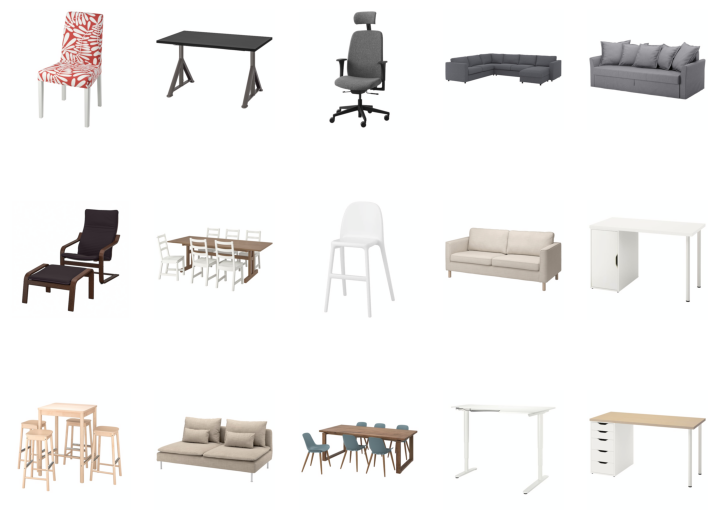

In [133]:
tiny_idxs = np.random.choice(range(len(train_data)), 15, replace=False)
tiny_data  = torch.utils.data.Subset(train_data, tiny_idxs)
plot_images(tiny_data)

## 3. Use cleanlab and feature embeddings to find outliers in the data
### Represent each image as a numeric feature embedding vector

In [134]:
# Generates 2048-dimensional feature embeddings from images
def embed_images(model, dataloader):
    feature_embeddings = []
    for data in tqdm(dataloader):
        images, labels = data
        with torch.no_grad():
            embeddings = model(images.cuda()).cpu()
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings  # each row corresponds to embedding of a different image

In [136]:
# Load pretrained neural network
model = timm.create_model('vit_base_patch14_dinov2', pretrained=True, num_classes=0)  # this is a pytorch network
model.cuda()
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
batch_size = 32
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

# Generate feature embeddings
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')

  0%|          | 0/85 [00:00<?, ?it/s]

Train embeddings pooled shape: (2691, 768)


In [96]:
import numpy as np
import umap

reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric="cosine"
)
umap_embeddings = reducer.fit_transform(train_feature_embeddings / np.linalg.norm(train_feature_embeddings, axis=-1)[:, None])
umap_embeddings.shape

(3174, 2)

In [97]:
x, y = umap_embeddings[:, 0].flatten(), umap_embeddings[:, 1].flatten()

In [98]:
df["x"] = x
df["y"] = y

df[[
    "url", "cluster1", "cluster2", "cluster3", 
    "product_header", "product_details", "good_to_know_details", "materials_details", 
    "image_url", "image_path", "label", "x", "y"
]].to_csv("dataset_only_main_images.csv", index=False)

### Scoring outliers in a given dataset

Fitting OOD estimator based on provided features ...
26


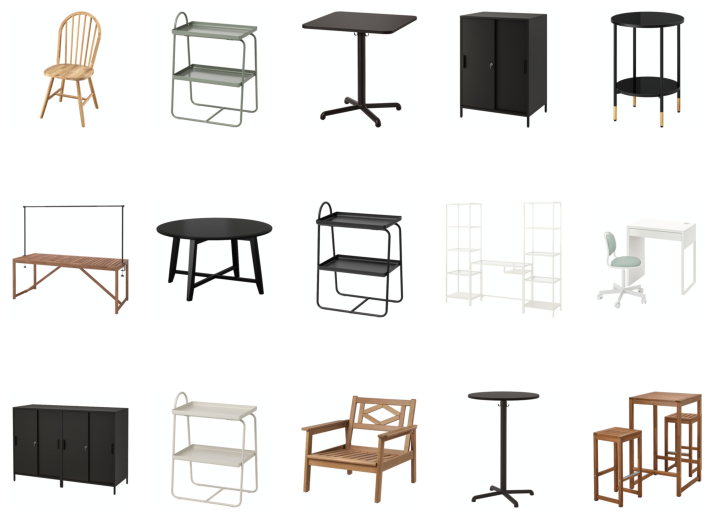

In [141]:
ood = OutOfDistribution()
train_ood_features_scores = ood.fit_score(features=train_feature_embeddings)

# top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=5)
tmp_idxs = np.where((train_ood_features_scores < 0.01))[0]

print(len(tmp_idxs))
visualize_outliers(tmp_idxs[:15], train_data)

### Deciding which examples are outliers

0.03242922201752663


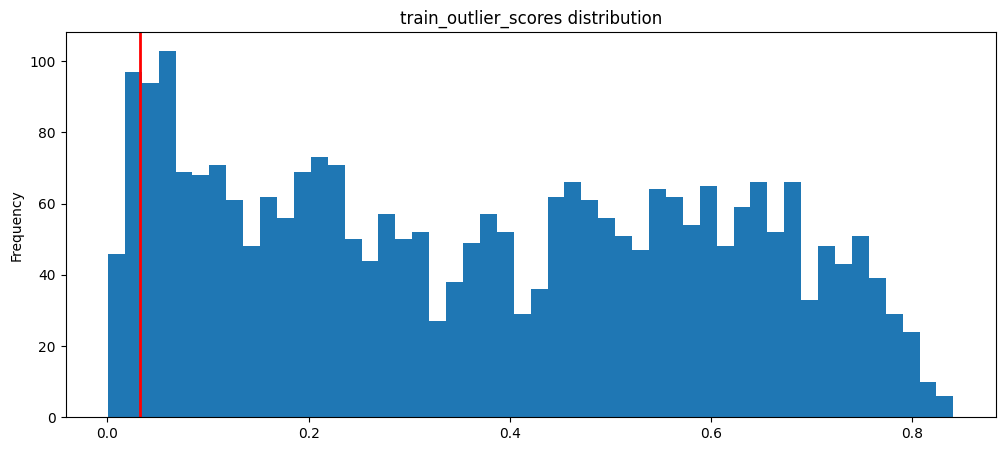

In [144]:
fifth_percentile = np.percentile(train_ood_features_scores, 5)  # 5th percentile of the train_data distribution
print(fifth_percentile)

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
plt_range = [train_ood_features_scores.min(), train_ood_features_scores.max()]
axes.hist(train_ood_features_scores, range=plt_range, bins=50)
axes.set(title='train_outlier_scores distribution', ylabel='Frequency')
axes.axvline(x=fifth_percentile, color='red', linewidth=2)

plt.show()

In [ ]:
df_filtered = df[train_ood_features_scores > fifth_percentile].reset_index(drop=True)
df_filtered.to_csv("dataset_filtered.csv", index=False)

In [145]:
df_filtered.shape[0]

2691

In [150]:
not_allowed_words = [
    "table-top",
    "tabletop",
    "pad",
    "storage"
]
df_filtered[df_filtered["image_url"].str.contains("|".join(not_allowed_words))]["url"].tolist()
df_filtered.to_csv("dataset_filtered.csv", index=False)